# Troll tweets

In [ ]:
import pathlib
import sklearn
import numpy
import nltk
import pandas as pd
import glob
import os
import advertools as adv
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import matplotlib.style as style

sns.set_palette("muted", 10)
style.use('seaborn-whitegrid')
sns.set()

In [ ]:
path = '../russian-troll-tweets/'                    # use your path

all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    print("Loaded:", filename)
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
english_only =  frame.loc[frame['language'] == 'English']  

In [ ]:
no_retweets = english_only.loc[(english_only['post_type'] != 'RETWEET') & (english_only['post_type'] != 'QUOTE_TWEET') ]

In [ ]:
right_trolls = no_retweets.loc[no_retweets['account_category'] == 'RightTroll']
left_trolls = no_retweets.loc[no_retweets['account_category'] == 'LeftTroll']
hashtag_gamer = no_retweets.loc[no_retweets['account_category'] == 'HashtagGamer']
fake_news = no_retweets.loc[no_retweets['account_category'] == 'NewsFeed']

#TODO run general analysis Tweet amounts time stamps over all sentiments general ideas

## Right Trolls

In [170]:
r_hashtag_summary = adv.extract_hashtags(right_trolls['content'])

In [ ]:
r_hashtag_summary['overview']

In [ ]:
r_hashtag_summary['hashtag_freq'][:15]

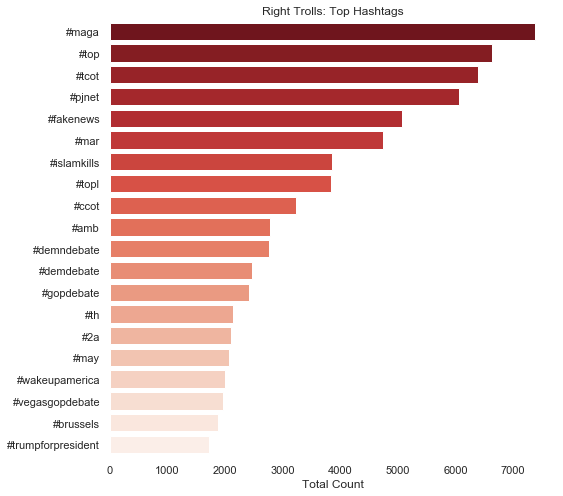

In [174]:
plt.figure(figsize=(8, 8))
ax = sns.barplot(
    [x[1] for x in r_hashtag_summary['top_hashtags'][:][:20]],
    [x[0] for x in r_hashtag_summary['top_hashtags'][:][:20]],
    palette="Reds_r")
ax.set_xlabel('Total Count')
plt.title('Right Trolls: Top Hashtags')
plt.gca().set_frame_on(False)

In [ ]:
r_emoji_summary = adv.extract_emoji(right_trolls['content'])

In [ ]:
plt.figure(figsize=(8, 8))
ax = sns.barplot(
    [x[1] for x in r_emoji_summary['top_emoji_text'][:20]],
    [x[0] for x in r_emoji_summary['top_emoji_text'][:20]],
    palette='Reds_r')
ax.set_xlabel('Total Count')
plt.title('Right Trolls: Top Emoji')
plt.gca().set_frame_on(False)

In [ ]:
r_mention_summary = adv.extract_mentions(right_trolls['content'])

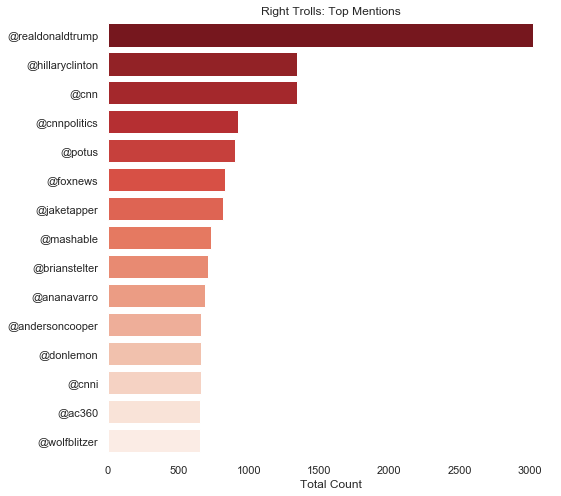

In [173]:
plt.figure(figsize=(8, 8))
ax = sns.barplot(
    [x[1] for x in r_mention_summary['top_mentions'][:15]],
    [x[0] for x in r_mention_summary['top_mentions'][:15]],
    palette='Reds_r')
ax.set_xlabel('Total Count')
plt.title('Right Trolls: Top Mentions')
plt.gca().set_frame_on(False)

In [ ]:
#?? Not sure about this one
r_question_summary = adv.extract_questions(right_trolls['content'])

In [ ]:
[(i,x) for i, x in  enumerate(r_question_summary['question_text']) if x][:15]

### NER

In [ ]:
from pprint import pprint ### needed to print python data more elegantly
import nltk 
import spacy

model="en_core_web_sm"

nlp = spacy.load(model)

r_entity_list = []

i = 0
for index, row in right_trolls.iterrows():
    if i % 1000 == 0:
        print(i)
    
        
#     print (index , row["content"]) 
    doc = nlp(row["content"])
    for ent in doc.ents:
#         print(ent.text.lower(), ent.label_)
        r_entity_list.append((ent.text.lower(), ent.label_, i ))
    
    i+= 1


# print(r_entity_list)        

r_entities_df = pd.DataFrame(data=r_entity_list , columns = ['Entity', 'Type', 't_index'])
r_entities_df

# from nltk.chunk import ne_chunk
# tokens = nltk.word_tokenize(test_string)
# tokens_pos_tagged = nltk.pos_tag(tokens)
# tokens_pos_tagged_and_named_entities = ne_chunk(tokens_pos_tagged)
# print()
# print('ORIGINAL SENTENCE', sentence)
# print('NAMED ENTITY RECOGNITION OUTPUT', tokens_pos_tagged_and_named_entities)

In [ ]:
r_entities_df.to_csv('r_entities_new.csv')

In [ ]:
r_entities_df = pd.read_csv('r_entities_new.csv')

Text(0.5, 0, 'NE type counts (log scale)')

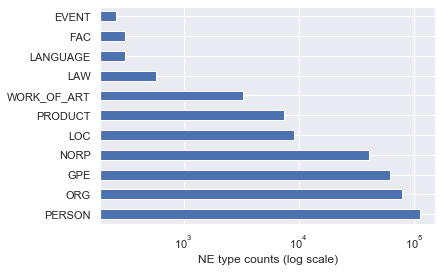

In [172]:
# canonicalize relevant entities
r_entities_df = r_entities_df.replace('donald trump', 'trump', regex=False)
r_entities_df = r_entities_df.replace('hillary clinton', 'hillary', regex=False)
r_entities_df = r_entities_df.replace('clinton', 'hillary', regex=False)
r_entities_df = r_entities_df.replace('bernie sanders', 'sanders', regex=False)
r_entities_df = r_entities_df.replace('bernie', 'sanders', regex=False)
r_entities_df = r_entities_df.replace('barack obama', 'obama', regex=False)
r_entities_df = r_entities_df.replace('barack', 'obama', regex=False)
r_entities_df = r_entities_df.replace('u.s.', 'usa', regex=False)
r_entities_df = r_entities_df.replace('us', 'usa', regex=False)
r_entities_df = r_entities_df.replace('america', 'usa', regex=False)
r_entities_df = r_entities_df.replace('dems', 'democrats', regex=False)
r_entities_df = r_entities_df.replace('the white house', 'white house', regex=False)
# remove irrelevant NE types
r_entities_df = r_entities_df.query(
    "not Type in ['MONEY', 'DATE','ORDINAL', 'CARDINAL', 'TIME', 'PERCENT', 'QUANTITY']")
# keep only NEs containing alphabetic chars
r_entities_df = r_entities_df[r_entities_df.Entity.str.isalpha()]
# quick plot of NE types
ax = r_entities_df['Type'].value_counts().plot.barh()
ax.set_xscale('log')
ax.set_xlabel('NE type counts (log scale)')

In [ ]:
# top 50 named entities for right trolls
counts = r_entities_df.Entity.value_counts().iloc[:50]
counts

In [ ]:
from nltk.sentiment import vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer


vader_model = SentimentIntensityAnalyzer()

# print(right_trolls.columns)


print(right_trolls.iloc[406190]['content'])
right_score_list = {}

for index, row in counts.iteritems():
    print(index, row)
    right_score_list[index] = []
    filtered_entities = r_entities_df.loc[(r_entities_df['Entity'] == index)]
    filtered_indices = filtered_entities.iloc[:]["t_index"]
    for t_index in filtered_indices:
#         print(t_index)
#         print(right_trolls.iloc[t_index - 1]['content'])
        scores = vader_model.polarity_scores(right_trolls.iloc[t_index - 1]['content'])
#         print('Score: ', scores)
        right_score_list[index].append(scores)
        
    right_score_list[index] = pd.DataFrame(data=right_score_list[index])
    
    right_trolls.iloc[filtered_indices]
    for t_idx, tweet_row in filtered_entities.iterrows():
        print(tweet_row)

In [ ]:
# ONLY RUN IF YOU DON'T HAVE `sents.pickle'
import pickle
from tqdm.auto import tqdm

arr_sents = []
for index, row in tqdm(no_retweets[:50].iterrows()):
    scores = vader_model.polarity_scores(str(row['content']))       
    arr_sents.append([index, scores['compound']])

t_sents = pd.DataFrame(arr_sents, columns=['t_index', 'sentiment'])
pickle.dump(t_sents, open("sents.pickle", "wb"))

In [ ]:
import pickle
t_sents = pickle.load(open("sents.pickle", "rb" ))
# the dataset may be biased towards negative or positive sentiment
# we'll calculate an offset to account for this bias
compound_sent_offset = np.mean(t_sents.sentiment)
compound_sent_offset

In [ ]:
import numpy as np

for index, row in counts.iteritems():
    right_score_list[index] = []
    filtered_entities = r_entities_df.loc[(r_entities_df.Entity == index)]
    filtered_indices = filtered_entities.iloc[:]["t_index"]
    for i, t_index in enumerate(filtered_indices):
        right_score_list[index].append(sents.iloc[t_index])

np.mean(right_score_list['trump'])

# for index in right_score_list:
#     df = right_score_list[index]
#     print()
#     print(index)
#     print(df)
#     print('Mean: ', df.mean())
#     filtered_df = df.loc[df['neu'] < 0.95 ]
#     print('Filtered Mean: ', filtered_df.mean())
    
#     english_only.loc[(english_only['post_type'] != 'RETWEET')


In [ ]:
from nltk.sentiment import vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer


vader_model = SentimentIntensityAnalyzer()

# print(right_trolls.columns)
# print(right_trolls.iloc[406190]['content'])
right_score_list = {}

for index, row in counts.iteritems():
    print(index, row)
    right_score_list[index] = []
    filtered_entities = r_entities_df[r_entities_df.Entity == index]
    filtered_indices = filtered_entities.iloc[:]["t_index"]
    for t_index in filtered_indices:
        content = right_trolls.iloc[t_index - 1]['content']
        scores = vader_model.polarity_scores(content)
        right_score_list[index].append(scores['compound'])

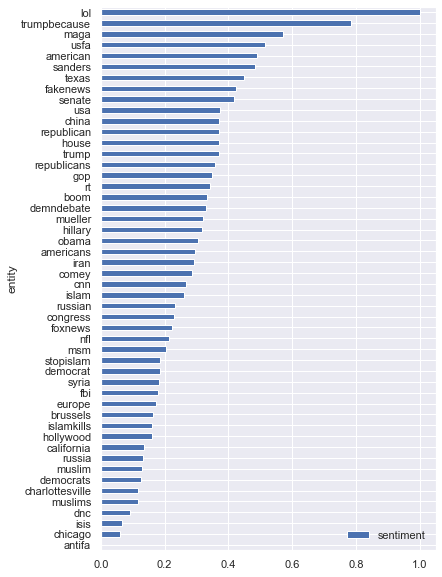

In [171]:
arr_sents_mean = []
for key, value in right_score_list.items():
    arr_sents_mean.append([key, np.mean(value)])
r_sentiments_df = pd.DataFrame(arr_sents_mean, columns=['entity', 'sentiment'])
x = r_sentiments_df.sentiment.values
x = (x-np.max(x))
x_scaled =(x-np.min(x))/(np.max(x)-np.min(x))
r_sentiments_df.sentiment = x_scaled
ax = r_sentiments_df.sort_values(by='sentiment').plot.barh(y='sentiment', x='entity')
ax.figure.set_size_inches(6,10)